# TP: Adversarial Bandits
### Thomas Jacquemin MS IA 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In the lecture, we saw the adversarial bandit framework as a game between a player and nature. In fact, there is a strong connexion between regret minimization and game theory. In this practical session, we will apply the EXP3 algorithm to a sequential two-player zero sum game.  
  
We consider the sequential version of a two-player zero-sum games between a player and an adversary.

Let $L \in [-1, 1]^{M*N}$ be a loss matrix.
  
At each round $t = 1, ... , T$  
– The player choose a distribution $p_t \in \Delta_M := \{p \in [0, 1]^M, \sum_{i=1}^{M} p_i = 1\}$  
– The adversary chooses a distribution $q_t \in \Delta_N$  
– The actions of both players are sampled $i_t \sim p_t$ and $j_t \sim q_t$  
– The player incurs the loss $L(i_t, j_t)$ and the adversary the loss $-L(i_t, j_t)$

<center>Setting 1: Setting of a sequential two-player zero sum game</center>

1. Define $M$, $N$ and a loss matrix $L \in [-1, 1]^{M*N}$ that corresponds to the game “Rock paper scissors”

In [2]:
M = 3
N = 3
rock_paper_scissors_L = np.array([[0, 1, -1],
                                  [-1, 0, 1],
                                  [1, -1, 0]])

## Full information feedback  

In this part, we assume that both players know the matrix L in advance and can compute $L(i, j)$ for any $(i, j)$.

2. Implementation of `EWA`.

(a) In order to implement the exponential weight algorithm, you need a way to sample from the exponential weight distribution. Implement the function `rand_exp` that takes as input a probability vector $p \in \Delta_M$ and uses a single call to `rand()` to return $X \in [M]$ with $P(X = i) = p_i$.

In [3]:
def rand_exp(probabilities):
    return np.random.choice(np.arange(len(probabilities)), p=probabilities)

In [4]:
# Quick test
probabilities = np.array([0.2, 0.6, 0.2])
rand_exp(probabilities)

1

(b) Define a function `EWA_update` that takes as input a vector $p_t \in \Delta_M$ and a loss vector $l_t \in [-1, 1]^M$ and
return the updated vector $p_{t+1} \in \Delta_M$ defined for all $i \in [M]$ by

$$p_{t+1}(i) = \frac{p_t(i)exp(-\eta l_t(i))}{\sum_{j=1}^{M}p_t(j)exp(-\eta l_t(j))}$$

In [5]:
def EWA_update(weights, loss_vect, learning_rate, **kwargs):
    return weights * np.exp(-learning_rate * loss_vect) / np.sum( weights * np.exp(-learning_rate * loss_vect) )

3. Simulation against a fixed adverary. Consider the game “Rock paper scissors” and assume that the adversary chooses $q_t = (1/2, 1/4, 1/4)$ and samples $j_t \sim q_t$ for all rounds $t >= 1$.

(a) What is the loss $l_t(i)$ incurred by the player if he chooses action $i$ at time $t$? Simulate an instance of the game for $t = 1, . . . , T = 100$ for $\eta = 1$.

**answer:** At each time $t$, the adversary choose an action according to $q_t$ which is always the same for any $t$. We can look in the Loss matrix $L$ the corresponding loss vector $l_t$ for the player.

In [6]:
# Adversary strategy
q = np.array([1/2, 1/4, 1/4])

adversary_action = rand_exp(q) 
print('Adversary chooses action {}'.format(adversary_action))

#Player loss vector
l = rock_paper_scissors_L[:, adversary_action]
print('Player loss vector: {}'.format(l))
print('Loss incurred by action 0: {}'.format(l[0]))
print('Loss incurred by action 1: {}'.format(l[1]))
print('Loss incurred by action 2: {}'.format(l[2]))

Adversary chooses action 2
Player loss vector: [-1  1  0]
Loss incurred by action 0: -1
Loss incurred by action 1: 1
Loss incurred by action 2: 0


In [14]:
def rock_paper_scissors_sim(T=100,
                            L = rock_paper_scissors_L,
                            player_update_algo=EWA_update,
                            player_learning_rate=1,
                            adaptive_adversary=False,
                            adversary_update_algo=EWA_update,
                            adversary_learning_rate=0.05,
                            p_init = None,
                            q_init = None):
    
    M = L.shape[0]
    N = L.shape[1]
    
    # Initial p_0 for the player
    if p_init is None:
        p_t = np.array([1/M for _ in range(M)])
    else:
        p_t = p_init
        
    # Initial q_0 for the adversary
    if q_init is None:
        q_t = np.array([1/N for _ in range(N)])
    else:
        q_t = q_init
    
    # Tracking q_t evolution
    q_weight_vectors = np.zeros((T+1,3))
    q_weight_vectors[0] = q_t
    
    # Tracking p_t evolution
    weight_vectors = np.zeros((T+1,3))
    weight_vectors[0] = p_t

    # Tracking loss evolution
    loss = np.zeros(T)
    average_loss_t = 0
    average_loss = np.zeros(T)
    
    for t in range(T):
        # Players choose their action
        adversary_action = rand_exp(q_t)
        player_action = rand_exp(p_t)

        # Computing loss
        l_t = L[:, adversary_action]
        loss_t = l_t[player_action]
        loss[t] = loss_t

        # Average loss at time t
        average_loss_t += (loss_t-average_loss_t) / (t+1)
        average_loss[t] = average_loss_t

        # Update player strategy
        p_t = player_update_algo(weights=p_t,
                                 loss_vect=l_t,
                                 loss=loss_t,
                                 learning_rate=player_learning_rate,
                                 chosen_action=player_action)
        weight_vectors[t+1] = p_t
        
        # Update adversary strategy
        if adaptive_adversary:
            adv_l_t = -L[player_action, :]
            adversary_loss_t = adv_l_t[adversary_action]
            q_t = adversary_update_algo(weights=q_t,
                                        loss_vect=adv_l_t,
                                        loss=adversary_loss_t,
                                        learning_rate=adversary_learning_rate,
                                        chosen_action=adversary_action)
        q_weight_vectors[t+1] = q_t
    
    # Cumulative regret for every t
    cumulative_regret = np.cumsum(loss - (-1))
    
    game_result = 'loses' if average_loss[-1] > 0 else 'wins'
    print('Over {} rounds, player {} versus the adversary!'.format(T, game_result))
    
    results = {'weight_vectors' : weight_vectors,
               'loss' : loss,
               'average_loss' : average_loss,
               'cumulative_regret' : cumulative_regret,
               'q_weight_vectors' : q_weight_vectors}
    
    return results

In [15]:
# 100 rounds for this simulation
simulation = rock_paper_scissors_sim(T=100,
                                     q_init=np.array([1/2, 1/4, 1/4]))

Over 100 rounds, player wins versus the adversary!


(b) Plot the evolution of the weight vectors $p_1$, $p_2$, . . . , $p_T$ . What seems to be the best strategy against this
adversary?

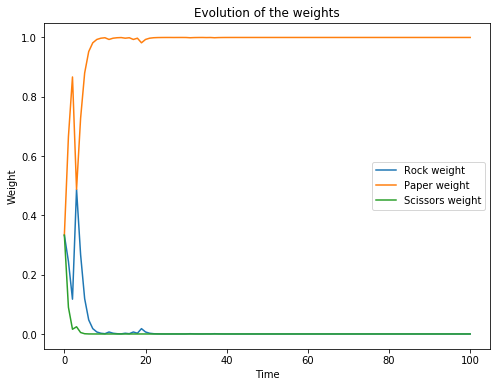

In [16]:
weight_vectors = simulation['weight_vectors']

# Weights plot
plt.figure(figsize=(8,6))
plt.title('Evolution of the weights')
plt.plot(weight_vectors[:, 0], label='Rock weight')
plt.plot(weight_vectors[:, 1], label='Paper weight')
plt.plot(weight_vectors[:, 2], label='Scissors weight')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.legend()
plt.show()

**answer**: We see clearly with the evolution of the weights that the best action tends to be *Paper*. As the adversary tends to choose *Rock* more often, that seems to be a correct result.

(c) Plot the average loss $l_t = \sum_{s=1}^{t} l(i_s, j_s)$ as a function of $t$.

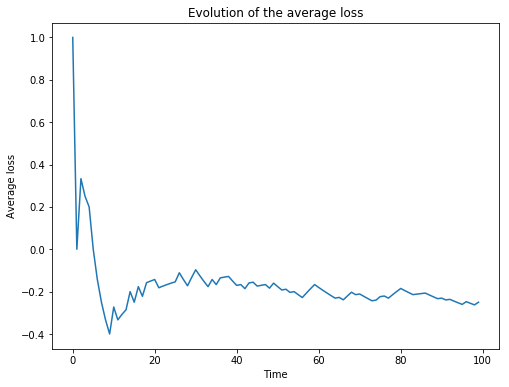

In [17]:
# Average loss plot
plt.figure(figsize=(8,6))
plt.title('Evolution of the average loss')
plt.plot(simulation['average_loss'])
plt.xlabel('Time')
plt.ylabel('Average loss')
plt.show()

(d) Plot the cumulative regret.

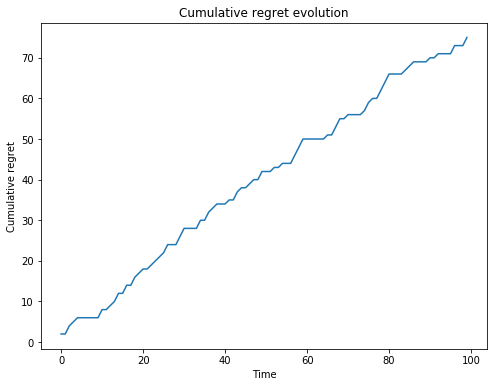

In [18]:
# cumulative regret plot
plt.figure(figsize=(8,6))
plt.title('Cumulative regret evolution')
plt.plot(simulation['cumulative_regret'])
plt.xlabel('Time')
plt.ylabel('Cumulative regret')
plt.show()

(e) To see if the algorithm is stable, repeat the simulation `n = 10` times and plot the average loss $(\overline{l_t})_{t>=1}$ obtained in average, in maximum and in minimum over the `n` simulations.

In [19]:
# Number of simulations
n = 10

first_simulation = True

# Doing n simulations
for i in range(n):
    simulation = rock_paper_scissors_sim(T=100,
                                         q_init=np.array([1/2, 1/4, 1/4]))
    avg_loss = simulation['average_loss']
    
    if first_simulation:
        maximum_avg_loss = np.copy(avg_loss)
        global_average_loss = np.copy(avg_loss)
        minimum_avg_loss = np.copy(avg_loss)
        first_simulation = False
        continue
    
    for t in range(len(avg_loss)):
        if avg_loss[t] < minimum_avg_loss[t]:
            minimum_avg_loss[t] = avg_loss[t]
            
        if avg_loss[t] > maximum_avg_loss[t]:
            maximum_avg_loss[t] = avg_loss[t]
        
        global_average_loss[t] += (avg_loss[t] - global_average_loss[t]) / (i+1)

Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player loses versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!


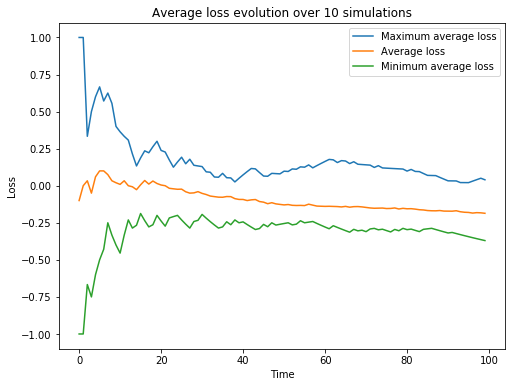

In [20]:
# Plot of the average loss evolution over n simulations
plt.figure(figsize=(8,6))
plt.title('Average loss evolution over {} simulations'.format(n))
plt.plot(maximum_avg_loss, label='Maximum average loss')
plt.plot(global_average_loss, label='Average loss')
plt.plot(minimum_avg_loss, label='Minimum average loss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.legend()
plt.show()

(f) Repeat one simulation for different values of learning rates $\eta \in \{0.01, 0.05, 0.1, 0.5, 1\}$ and plot the final regret as a function of $\eta$. What are the best $\eta$ in practice and in theory.

In [23]:
learning_rates = [0.01, 0.05, 0.1, 0.5, 1]
final_regrets = np.zeros(len(learning_rates))

for i, learning_rate in enumerate(learning_rates):
    simulation = rock_paper_scissors_sim(player_learning_rate=learning_rate,
                                         q_init=np.array([1/2, 1/4, 1/4]))
    final_regret = simulation['cumulative_regret'][-1]
    final_regrets[i] = final_regret

Over 100 rounds, player loses versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!


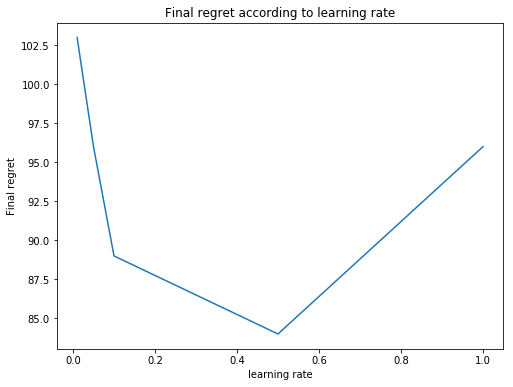

In [24]:
# Plot of final regret according to learning rate
plt.figure(figsize=(8,6))
plt.title('Final regret according to learning rate'.format(n))
plt.plot(learning_rates, final_regrets)
plt.xlabel('learning rate')
plt.ylabel('Final regret')
plt.show()

4. Simulation against an adaptive adversary. Repeat the simulation of question 3) when the adversary is also playing `EWA` with learning parameters $\eta = 0.05$.

In [26]:
simulation = rock_paper_scissors_sim(T=100,
                                     player_learning_rate=0.5,
                                     adaptive_adversary=True,
                                     adversary_learning_rate=0.05,
                                     q_init=np.array([1/2, 1/4, 1/4]))

Over 100 rounds, player loses versus the adversary!


(a) Plot $\frac{1}{t} \sum_{s=1}^{t}l(i_s, j_s)$ as a function of $t$.

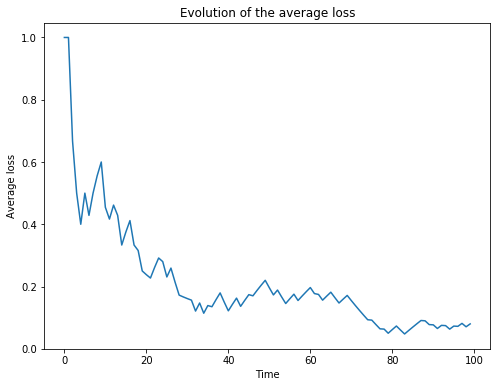

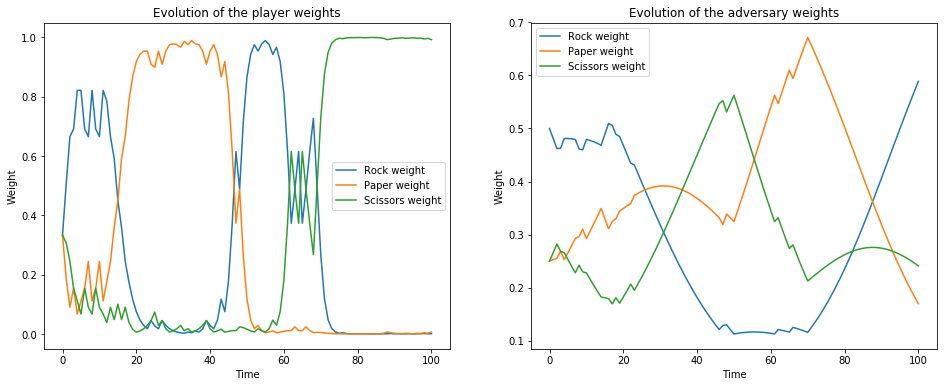

In [27]:
avg_loss = simulation['average_loss']

# Average loss plot
plt.figure(figsize=(8,6))
plt.title('Evolution of the average loss')
plt.plot(avg_loss)
plt.xlabel('Time')
plt.ylabel('Average loss')
plt.show()

# Evolution of player weights
weight_vectors = simulation['weight_vectors']

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('Evolution of the player weights')
plt.plot(weight_vectors[:, 0], label='Rock weight')
plt.plot(weight_vectors[:, 1], label='Paper weight')
plt.plot(weight_vectors[:, 2], label='Scissors weight')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.legend()

# Evolution of Adversary weights
q_weight_vectors = simulation['q_weight_vectors']

plt.subplot(1,2,2)
plt.title('Evolution of the adversary weights')
plt.plot(q_weight_vectors[:, 0], label='Rock weight')
plt.plot(q_weight_vectors[:, 1], label='Paper weight')
plt.plot(q_weight_vectors[:, 2], label='Scissors weight')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.legend()
plt.show()

(b) Define $\overline{p_t} = \frac{1}{t} \sum_{s=1}^{t}p_s$. Plot in log scale $\|\overline{p_t} - (1/3, 1/3, 1/3)\|_2$ as a function of $t$.

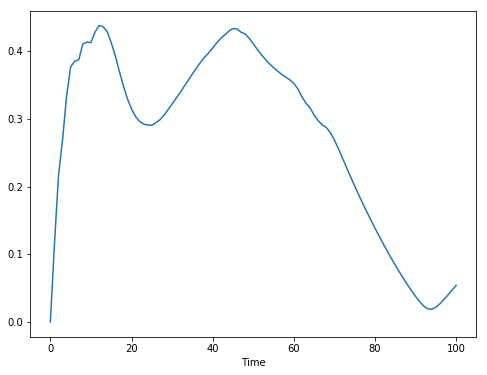

In [28]:
weight_vectors = simulation['weight_vectors']
avg_p_t = np.cumsum(weight_vectors, axis=0)

for t in range(0, len(avg_p_t)):
    avg_p_t[t] /= t+1
    avg_p_t[t][0] -= 1/3
    avg_p_t[t][1] -= 1/3
    avg_p_t[t][2] -= 1/3

# Average loss plot
plt.figure(figsize=(8,6))
plt.plot(np.linalg.norm(avg_p_t, axis=1))
plt.xlabel('Time')
plt.show()

## Bandit feedback

Now, we assume that the players do not know the game in advance but only observe the performance $L(i_t, j_t)$ (that we assume here to be in $[0, 1]$) of the actions played at time $t$. They need to learn the game and adapt to the adversary as one goes along.

5. Implementation of `EXP3`. Since both players are symmetric, we focus on the first player.

(a) Implement the function `estimated_loss` that takes as input the action $i_t \in [M]$ played at round $t >= 1$ and the loss $L(i_t, j_t)$ suffered by the player and return the vector of estimated loss $\widehat{l_t} \in R^M_+$ used by `EXP3`.

In [29]:
def estimated_loss(weights, chosen_action, loss):
    estimated_loss_vector = np.zeros(len(weights))
    estimated_loss_vector[chosen_action] = loss
    return estimated_loss_vector / weights

(b) Implement the function `EXP3_update` that takes as input a vector $p_t \in \Delta_M$, the action $i_t \in [M]$ played by
the player and the loss $L(i_t, j_t)$ and return the updated weight vector $p_{t+1} \in \Delta_M$.

In [30]:
def EXP3_update(weights, chosen_action, loss, learning_rate, **kwarg):
    estimated_loss_vector = estimated_loss(weights, chosen_action, loss)
    return EWA_update(weights, estimated_loss_vector, learning_rate)

6. Repeat Questions 3.a) to 3.f) with `EXP3` instead of `EWA`.

In [31]:
# 100 rounds for this simulation
# This time we use the EXP3 algorithm for the update
simulation = rock_paper_scissors_sim(T=100,
                                     player_update_algo=EXP3_update,
                                     q_init=np.array([1/2, 1/4, 1/4]))

Over 100 rounds, player wins versus the adversary!


(b) Plot the evolution of the weight vectors $p_1$, $p_2$, . . . , $p_T$ . What seems to be the best strategy against this
adversary?

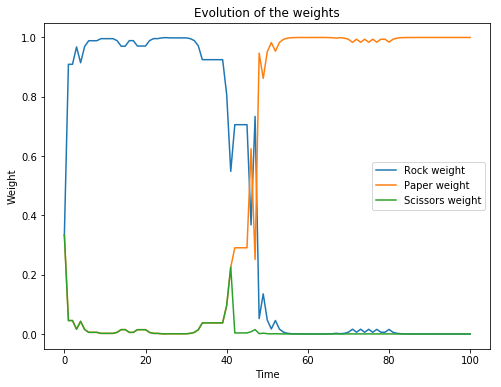

In [32]:
weight_vectors = simulation['weight_vectors']

# Weights plot
plt.figure(figsize=(8,6))
plt.title('Evolution of the weights')
plt.plot(weight_vectors[:, 0], label='Rock weight')
plt.plot(weight_vectors[:, 1], label='Paper weight')
plt.plot(weight_vectors[:, 2], label='Scissors weight')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.legend()
plt.show()

**answer**: We see clearly with the evolution of the weights that the best action tends to be *Paper*. As the adversary tends to choose *Rock* more often, that seems to be a correct result.

(c) Plot the average loss $l_t = \sum_{s=1}^{t} l(i_s, j_s)$ as a function of $t$.

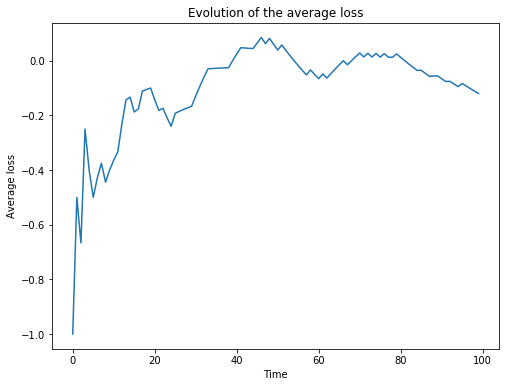

In [33]:
# Average loss plot
plt.figure(figsize=(8,6))
plt.title('Evolution of the average loss')
plt.plot(simulation['average_loss'])
plt.xlabel('Time')
plt.ylabel('Average loss')
plt.show()

(d) Plot the cumulative regret.

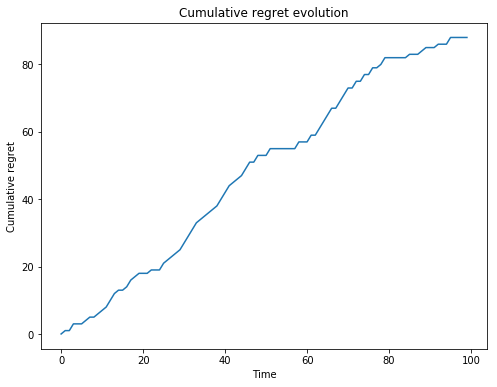

In [34]:
# cumulative regret plot
plt.figure(figsize=(8,6))
plt.title('Cumulative regret evolution')
plt.plot(simulation['cumulative_regret'])
plt.xlabel('Time')
plt.ylabel('Cumulative regret')
plt.show()

(e) To see if the algorithm is stable, repeat the simulation `n = 10` times and plot the average loss $(\overline{l_t})_{t>=1}$ obtained in average, in maximum and in minimum over the `n` simulations.

In [35]:
# Number of simulations
n = 10

first_simulation = True

# Doing n simulations
for i in range(n):
    simulation = rock_paper_scissors_sim(T=100,
                                         player_update_algo=EXP3_update,
                                         q_init=np.array([1/2, 1/4, 1/4]))
    
    avg_loss = simulation['average_loss']
    
    if first_simulation:
        maximum_avg_loss = np.copy(avg_loss)
        global_average_loss = np.copy(avg_loss)
        minimum_avg_loss = np.copy(avg_loss)
        first_simulation = False
        continue
    
    for t in range(len(avg_loss)):
        if avg_loss[t] < minimum_avg_loss[t]:
            minimum_avg_loss[t] = avg_loss[t]
            
        if avg_loss[t] > maximum_avg_loss[t]:
            maximum_avg_loss[t] = avg_loss[t]
        
        global_average_loss[t] += (avg_loss[t] - global_average_loss[t]) / (i+1)

Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player loses versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player loses versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player loses versus the adversary!


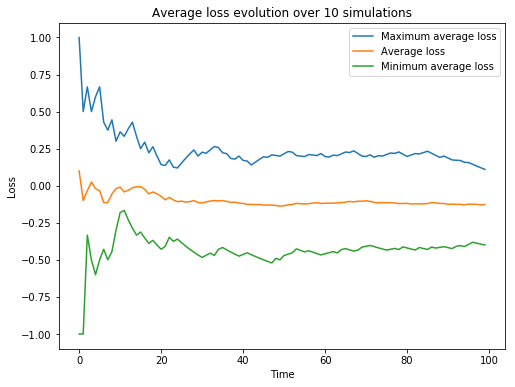

In [36]:
# Plot of the average loss evolution over n simulations
plt.figure(figsize=(8,6))
plt.title('Average loss evolution over {} simulations'.format(n))
plt.plot(maximum_avg_loss, label='Maximum average loss')
plt.plot(global_average_loss, label='Average loss')
plt.plot(minimum_avg_loss, label='Minimum average loss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.legend()
plt.show()

(f) Repeat one simulation for different values of learning rates $\eta ∈ \{0.01, 0.05, 0.1, 0.5, 1\}$ and plot the final regret as a function of $\eta$. What are the best $\eta$ in practice and in theory.

In [37]:
learning_rates = [0.01, 0.05, 0.1, 0.5, 1]
final_regrets = np.zeros(len(learning_rates))

for i, learning_rate in enumerate(learning_rates):
    simulation = rock_paper_scissors_sim(player_update_algo=EXP3_update,
                                         player_learning_rate=learning_rate,
                                         q_init=np.array([1/2, 1/4, 1/4]))
    final_regret = simulation['cumulative_regret'][-1]
    final_regrets[i] = final_regret

Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player wins versus the adversary!
Over 100 rounds, player loses versus the adversary!


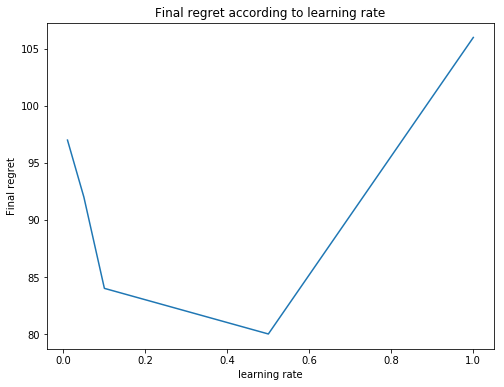

In [38]:
# Plot of final regret according to learning rate
plt.figure(figsize=(8,6))
plt.title('Final regret according to learning rate'.format(n))
plt.plot(learning_rates, final_regrets)
plt.xlabel('learning rate')
plt.ylabel('Final regret')
plt.show()

7. Repeat Question 4.a) and 4.b) with `EXP3` instead of `EWA`.

In [39]:
simulation = rock_paper_scissors_sim(T=100,
                                     player_update_algo=EXP3_update,
                                     player_learning_rate=1,
                                     adaptive_adversary=True,
                                     adversary_update_algo=EXP3_update,
                                     adversary_learning_rate=0.05,
                                     q_init=np.array([1/2, 1/4, 1/4]))

Over 100 rounds, player wins versus the adversary!


(a) Plot $\frac{1}{t} \sum_{s=1}^{t}l(i_s, j_s)$ as a function of $t$.

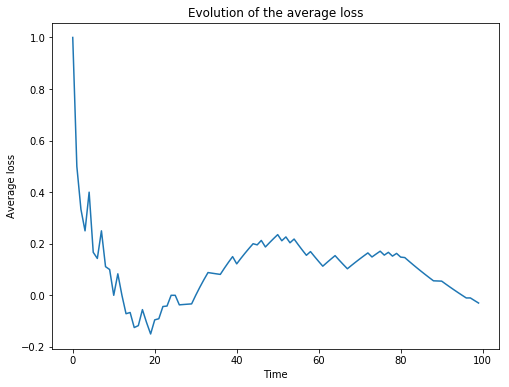

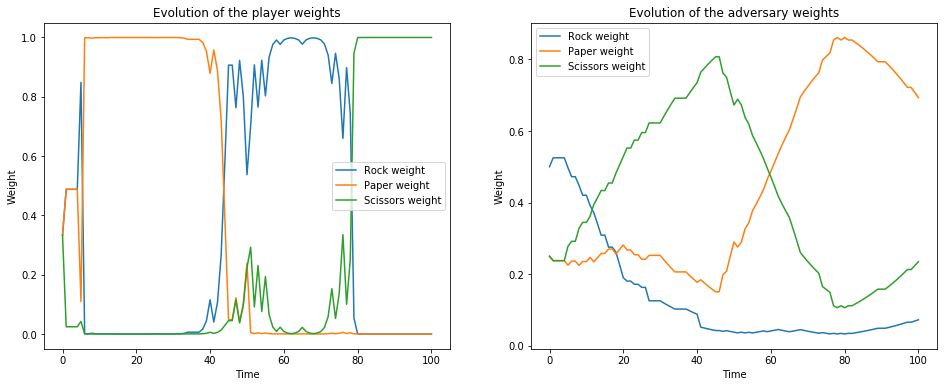

In [40]:
avg_loss = simulation['average_loss']

# Average loss plot
plt.figure(figsize=(8,6))
plt.title('Evolution of the average loss')
plt.plot(avg_loss)
plt.xlabel('Time')
plt.ylabel('Average loss')
plt.show()

# Evolution of player weights
weight_vectors = simulation['weight_vectors']

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('Evolution of the player weights')
plt.plot(weight_vectors[:, 0], label='Rock weight')
plt.plot(weight_vectors[:, 1], label='Paper weight')
plt.plot(weight_vectors[:, 2], label='Scissors weight')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.legend()

# Evolution of Adversary weights
q_weight_vectors = simulation['q_weight_vectors']

plt.subplot(1,2,2)
plt.title('Evolution of the adversary weights')
plt.plot(q_weight_vectors[:, 0], label='Rock weight')
plt.plot(q_weight_vectors[:, 1], label='Paper weight')
plt.plot(q_weight_vectors[:, 2], label='Scissors weight')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.legend()
plt.show()

(b) Define $\overline{p_t} = \frac{1}{t} \sum_{s=1}^{t}p_s$. Plot in log scale $\|\overline{p_t} - (1/3, 1/3, 1/3)\|_2$ as a function of $t$.

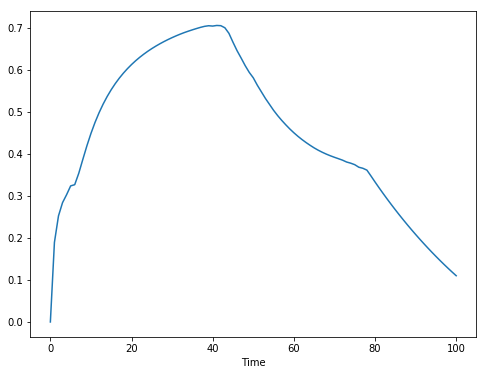

In [41]:
weight_vectors = simulation['weight_vectors']
avg_p_t = np.cumsum(weight_vectors, axis=0)

for t in range(0, len(avg_p_t)):
    avg_p_t[t] /= t+1
    avg_p_t[t][0] -= 1/3
    avg_p_t[t][1] -= 1/3
    avg_p_t[t][2] -= 1/3

# Average loss plot
plt.figure(figsize=(8,6))
plt.plot(np.linalg.norm(avg_p_t, axis=1))
plt.xlabel('Time')
plt.show()

## Optional extentions

8. Repeat Question 4.a) when the adversary is playing a `UCB` algorithm. Who wins between `UCB` and `EXP3`?

In [42]:
def ucb_get_action(t, nb_tries, cum_rewards, c=1):
    no_try_index = np.where(nb_tries == 0)[0]
    if np.size(no_try_index) > 0:
        return np.random.choice(no_try_index)
    return np.argmax(cum_rewards + c*(np.log(t)/nb_tries)**0.5)

In [43]:
def rock_paper_scissors_sim(T=100,
                            L = rock_paper_scissors_L,
                            player_update_algo=EWA_update,
                            player_learning_rate=1,
                            adaptive_adversary=False,
                            adversary_update_algo=EWA_update,
                            adversary_learning_rate=0.05,
                            adversary_ucb_c_param=1,
                            p_init = None,
                            q_init = None):
    M = L.shape[0]
    N = L.shape[1]
    
    # Initial p_0 for the player
    if p_init is None:
        p_t = np.array([1/M for _ in range(M)])
    else:
        p_t = p_init
        
    # Initial q_0 for the adversary
    if q_init is None:
        q_t = np.array([1/N for _ in range(N)])
    else:
        q_t = q_init
    
    # Tracking q_t evolution
    q_weight_vectors = np.zeros((T+1,3))
    q_weight_vectors[0] = q_t
    
    # Tracking p_t evolution
    weight_vectors = np.zeros((T+1,3))
    weight_vectors[0] = p_t

    # Tracking loss evolution
    loss = np.zeros(T)
    average_loss_t = 0
    average_loss = np.zeros(T)
    
    #UCB -> keeping track of nb_tries(action) and cum_reward(action)
    if adversary_update_algo == 'UCB':
        nb_tries = np.zeros(3, int)
        cum_rewards = np.zeros(3, int)
    
    for t in range(T):
        # Players choose their action
        if adaptive_adversary and adversary_update_algo == 'UCB':
            adversary_action = ucb_get_action(t, nb_tries, cum_rewards, adversary_ucb_c_param)
        else:
            adversary_action = rand_exp(q_t)

        player_action = rand_exp(p_t)

        # Computing loss for player
        l_t = L[:, adversary_action]
        loss_t = l_t[player_action]
        loss[t] = loss_t
        
        # Average loss at time t
        average_loss_t += (loss_t-average_loss_t) / (t+1)
        average_loss[t] = average_loss_t
        
        # Computing loss for adversary
        adv_l_t = -L[player_action, :]
        adversary_loss_t = adv_l_t[adversary_action]

        # Update player strategy
        p_t = player_update_algo(weights=p_t,
                                 loss_vect=l_t,
                                 loss=loss_t,
                                 learning_rate=player_learning_rate,
                                 chosen_action=player_action)
        weight_vectors[t+1] = p_t
        
        # Update adversary strategy
        if adaptive_adversary:
            if adversary_update_algo == 'UCB':
                nb_tries[adversary_action] += 1
                cum_rewards[adversary_action] += -adversary_loss_t
            else:
                adv_l_t = -L[player_action, :]
                adversary_loss_t = adv_l_t[adversary_action]
                q_t = adversary_update_algo(weights=q_t,
                                            loss_vect=adv_l_t,
                                            loss=adversary_loss_t,
                                            learning_rate=adversary_learning_rate,
                                            chosen_action=adversary_action)
        q_weight_vectors[t+1] = q_t
    
    # Cumulative regret for every t
    cumulative_regret = np.cumsum(loss - (-1))
    
    game_result = 'loses' if average_loss[-1] > 0 else 'wins'
    print('Over {} rounds, player {} versus the adversary!'.format(T, game_result))
    
    results = {'weight_vectors' : weight_vectors,
               'loss' : loss,
               'average_loss' : average_loss,
               'cumulative_regret' : cumulative_regret,
               'q_weight_vectors' : q_weight_vectors}
    
    return results

In [46]:
simulation = rock_paper_scissors_sim(player_update_algo=EXP3_update,
                                     player_learning_rate=0.5,
                                     adaptive_adversary=True,
                                     adversary_update_algo='UCB',
                                     adversary_ucb_c_param=1,
                                     q_init=np.array([1/2, 1/4, 1/4]))

Over 100 rounds, player loses versus the adversary!


9. In this lecture, we saw that `EXP3` has a sublinear expected regret. Yet, as shown by question 6.e), it is extremely unstable with a large variance. Implement `EXP3.IX` (see Chapter 12 of [1]) a modification of `EXP3` that controls the regret in expectation and simultaneously keeps it stable. Repeat question 3.e) with `EXP3.IX`

10. Try different games (not necessarily zero-sum games). In particular, how these algorithms behave for the prisoner’s dilemna (see wikipedia)? The prisoner’s dilemna is a two-player games that shows why two completely rational individuals might not cooperate, even if it appears that it is in their best interests to do so. The losses matrices are:
  
$$L^{(player)} = \begin{pmatrix} 1 & 3 \\ 0 & 2\end{pmatrix}$$ $$L^{(adversary)} = \begin{pmatrix} 1 & 0 \\ 3 & 2\end{pmatrix}$$